# Активное обучение для классификации изображений по качеству

## Описание данных и постановка задачи

Я участвую в проекте по генерации изображений. Сгенерированные изображения не всегда получаются качественными, а ручная валидация отнимает много времени. Поэтому появилась идея на ранее собранной разметке обучить классификатор с использованием активного обучения.

Размеченные изображения разделены на папки `good` и `bad`. Неразмеченные находятся в папке `unsorted`. Пайплан активного обучения выглядит следующим образом:
1. Обучаем модель на размеченных изображениях (50 эпох для первого раза, после - 15).
2. Получаем предсказания модели на неразмеченных данных.
3. Отбираем 20 самых неуверенных предсказаний.
4. Размечаем 20 отобранных примеров.
5. Размеченные картинки переносятся из папки `unsorted` в папки `good` и `bad`.

Шаги (1-5) повторяются несколько раз.

In [1]:
import os
import random
import shutil
import sys
from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import clear_output, display
from PIL import Image
from sklearn.metrics import f1_score
from torch import nn, sigmoid, softmax
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.models import resnet18
from tqdm.notebook import tqdm, trange

In [ ]:
torch.set_default_dtype(torch.float32)

## Датасет

In [224]:
for folder in ["bad", "good", "unsorted"]:
    print(f"{folder}: {len(os.listdir(folder))}")

bad: 349
good: 275
unsorted: 367


При создании датасета важно обращать внимание на то как данные делятся на обучающие и валидационные. Т.к. размеченные картинки добавляются в папки к ранее размеченным картинкам, их порядок меняется. Из-за этого в валидационную выборку могут попасть примеры, которые модель уже видела, что завысит качество модели на валидации. Поэтому для сохранения разделения предприняты следующие шаги:
1. При перемещении файлов в другую папку, добавляем к ним префиксы (0 для `bad`, 1 для `good`; можно было бы всегда добавлять 0, но, кажется, 0 и 1 более "красиво")
2. При формировании датасета сортируем и переворачиваем список названий картинок. Так размеченные примеры окажутся в конце.
3. При разделении на трейн и валидацию, каждый 5 пример берем на валидацию, остальные отправляем в трейн

In [232]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, bad_img_dir="bad", good_img_dir="good"):
        self.bad_img_dir = bad_img_dir
        self.good_img_dir = good_img_dir
        self.bad_img = self.select_images(self.bad_img_dir, 0.0)
        self.good_img = self.select_images(self.good_img_dir, 1.0)
        self.all_img = self.bad_img + self.good_img
        # сортируем и переворачиваем список, чтобы картинки с префиксами 1 и 0 в названии оказались в конце
        self.all_img = list(
            reversed(sorted(self.all_img, key=lambda x: x[0].split("/")[-1]))
        )

    def select_images(self, img_dir, target):
        img_names = [name for name in os.listdir(img_dir) if name.endswith(".png")]
        return [(os.path.join(img_dir, name), target) for name in img_names]

    def get_image(self, path) -> torch.Tensor:
        img = np.array(Image.open(path))
        img = transforms.ToTensor()(img)
        img = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )(img)
        return img

    def __len__(self) -> int:
        return len(self.all_img)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        if isinstance(idx, int):
            sample = self.all_img[idx]
            path, y = sample
            image = self.get_image(path)
            return {"path": path, "image": image, "y": y}

In [231]:
def get_loaders(
    dataset: Dataset, batch_size: int = 16, num_workers: int = 2
) -> Tuple[DataLoader, DataLoader]:
    indices = list(range(len(dataset)))
    # делим на трейн и тест фиксированным способом
    train_indices = [i for i in indices if i % 5 != 0]
    val_indices = [i for i in indices if i % 5 == 0]
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    val_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers
    )
    return train_loader, val_loader

In [233]:
dataset = Dataset()

In [234]:
train_loader, val_loader = get_loaders(dataset)

## Пайплайн обучения

In [175]:
class Trainer:
    def __init__(self, model, device, criterion, lr=1e-3):
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = torch.optim.Adam(list(self.model.parameters()), lr=lr)
        self.criterion = criterion

    def train(self, train_loader, val_loader, num_epochs):
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_history = []
        self.val_history = []
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}")
            self.model.train()
            loss_accum = 0
            f1_accum = 0
            for batch_num, batch in enumerate(tqdm(train_loader, leave=False)):
                self.model.zero_grad()
                _, x, y = batch.values()
                y = y.type(torch.float32).view(-1, 1)
                output = torch.sigmoid(self.model(x.to(self.device)))
                loss = self.criterion(output, y.to(self.device))
                loss.backward()
                self.optimizer.step()
                loss_accum += loss.item()
                f1 = self.compute_f1(output.cpu(), y)
                f1_accum += f1
                sys.stdout.write(f"\rTrain Loss: {loss}. Train F1: {f1}")
                sys.stdout.flush()

            train_loss = loss_accum / batch_num
            train_f1 = f1_accum / batch_num
            val_loss, val_f1 = self.eval(val_loader)

            self.train_loss_history.append((epoch, float(train_loss)))
            self.val_loss_history.append((epoch, float(val_loss)))
            self.train_history.append((epoch, train_f1))
            self.val_history.append((epoch, val_f1))
            self.plot_history()
            print(
                f"\nTrain Loss: {train_loss} Train F1: {train_f1} \nVal Loss: {val_loss} Val F1: {val_f1}"
            )

    def compute_f1(self, prediction, y_true):
        y_pred = torch.round(prediction)
        f1 = f1_score(y_true, y_pred.detach().numpy())
        return f1

    def eval(self, val_loader):
        self.model.eval()
        with torch.no_grad():
            f1_accum = 0
            loss_accum = 0
            for batch_num, batch in enumerate(tqdm(val_loader, leave=False)):
                _, x, y = batch.values()
                y = y.type(torch.float32).view(-1, 1)
                output = torch.sigmoid(self.model(x.to(self.device)))
                loss = self.criterion(output, y.to(self.device)).item()
                loss_accum += loss
                f1 = self.compute_f1(output.cpu(), y)
                f1_accum += f1
                sys.stdout.write(f"\rVal Loss: {loss}. Val F1: {f1}")
                sys.stdout.flush()
        val_f1 = f1_accum / batch_num
        return loss_accum / batch_num, val_f1

    def plot_history(self):
        clear_output(True)
        plt.clf()
        plt.plot(*zip(*self.train_loss_history), color="blue", label="train")
        plt.plot(*zip(*self.val_loss_history), color="red", label="val")
        plt.legend()
        plt.grid()
        plt.show()

## Обучение модели

In [189]:
resnet = resnet18(pretrained=True)
model = nn.Sequential(resnet, nn.Linear(list(resnet.parameters())[-1].shape[-1], 1))
device = "cuda" if torch.cuda.is_available() else "cpu"

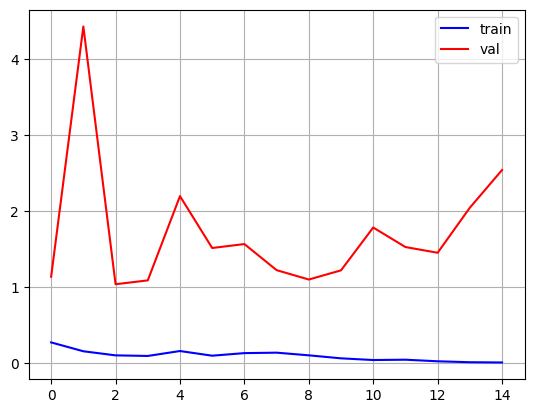


Train Loss: 0.011721638500919495 Train F1: 1.0260869565217392 
Val Loss: 2.5396350984988003 Val F1: 0.6157230390942868


In [223]:
trainer = Trainer(model, device, torch.nn.BCELoss())
trainer.train(train_loader, val_loader, 15)

## Отбираем неуверенные предсказания

In [239]:
def select_samples_for_annotation(n=20, img_dir="unsorted"):
    certainty_scores = []
    for img_name in os.listdir(img_dir):
        path = os.path.join(img_dir, img_name)
        prob = predict(path).item()
        certainty = measure_certainty(prob)
        certainty_scores.append((path, certainty))
    return sorted(certainty_scores, key=lambda x: x[1])[:n]


def predict(path):
    img = np.array(Image.open(path))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(
        img
    )
    x = img.unsqueeze(0)
    output = torch.sigmoid(model(x.to(device)))
    return output


def measure_certainty(prob):
    """Examples:
    x = 0.5;  f(x) = max(0.5, 0.5) = 0.5
    x = 0.01; f(x) = max(0.99, 0.01) = 0.99
    x = 0.99; f(x) = max(0.01, 0.99) = 0.99
    """
    return max(1 - prob, prob)

In [240]:
samples_for_annotation = select_samples_for_annotation()
paths_for_annotation = [path for path, _ in samples_for_annotation]

## Доразметка

In [192]:
def annotate_images(paths, bad_img_dir="bad", good_img_dir="good", start=0):
    for i, path in enumerate(paths, start=1):
        clear_output()
        image = Image.open(path)
        display(image)
        print(f"Image {i} out of {len(paths)}")
        print(path)
        fname = path.split("/")[-1]
        verdict = input('Press:\n"g" if the image is good,\n"b" if it is bad\n')
        # при перемещении файлов в другую папку, добавляем к ним префиксы
        if verdict == "g":
            shutil.move(path, os.path.join(good_img_dir, f"1_{fname}"))
        elif verdict == "b":
            shutil.move(path, os.path.join(bad_img_dir, f"0_{fname}"))

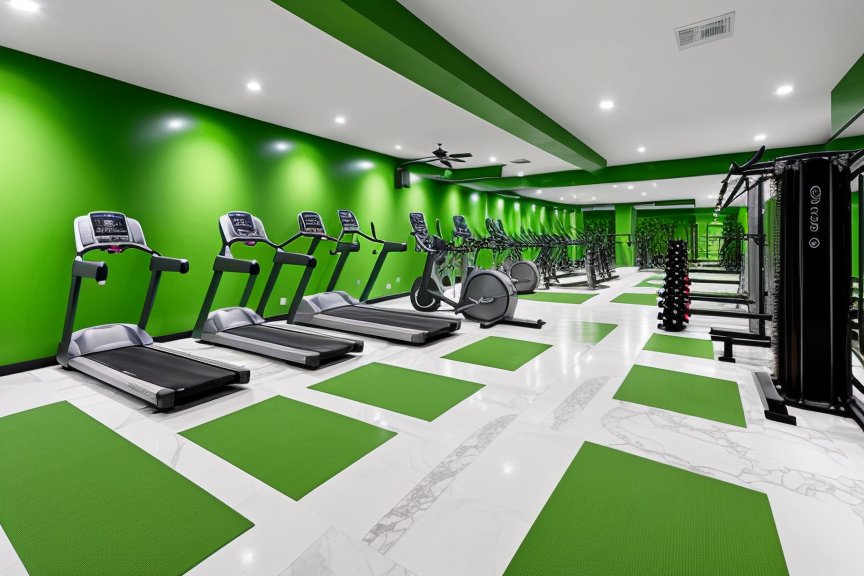

Image 20 out of 20
unsorted/health club_ "Elegant fitness haven_311970_gs9_68_steps.png


Press:
"g" if the image is good,
"b" if it is bad
 b


In [212]:
annotate_images(paths_for_annotation)

## Результат

В результате нескольких итераций активного обучения удалось повысить F1 на валидации с 0.5 до 0.6. Это не так много, но если использовать больше данных, думаю, можно получить зачительные улучшения.

Что касается данных, выбранных моделью для доразметки, если честно, не сказала бы, что они чем-то отличаются от остальных данных. Предполагается, что модель выбирает наиболее сложные примеры, но их разметка не показалась более сложной, чем разметка основной части данных. Скорее всего, потому что сложность разметки в понимании человека и в "понимании" модели это не обязательно одно и то же. Впрочем, наверное, это не так важно. Важнее то, насколько размеченные примеры помогают 